## Context-Aware Chatbot for Car Manuals using LLMs

You're working for a well-known car manufacturer who is looking at implementing LLMs into vehicles to provide guidance to drivers. You've been asked to experiment with integrating car manuals with an LLM to create a context-aware chatbot. They hope that this context-aware LLM can be hooked up to a text-to-speech software to read the model's response aloud.

As a proof of concept, you'll integrate several pages from a car manual that contains car warning messages and their meanings and recommended actions. This particular manual, stored as an HTML file, `mg-zs-warning-messages.html`, is from an MG ZS, a compact SUV. Armed with your newfound knowledge of LLMs and LangChain, you'll implement Retrieval Augmented Generation (RAG) to create the context-aware chatbot.

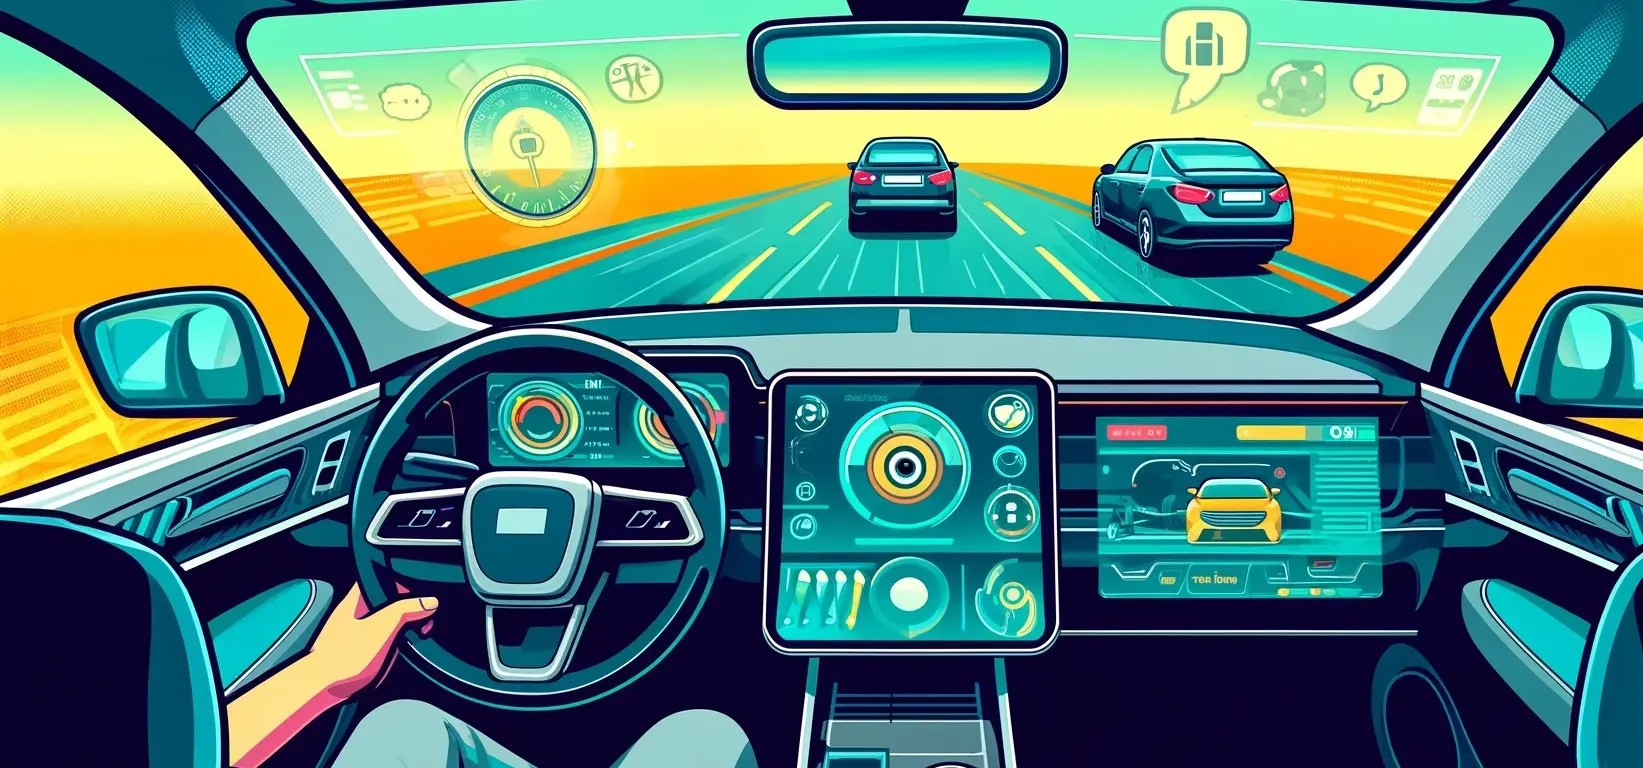

In [1]:
# Update your environment to Python 3.10 as described above before running this cell
import subprocess
import pkg_resources

def install_if_needed(package, version):
    '''Function to ensure that the libraries used are consistent to avoid errors.'''
    try:
        pkg = pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        subprocess.check_call(["pip", "install", f"{package}=={version}"])

install_if_needed("langchain", "0.2.2")
install_if_needed("langchain-openai", "0.1.8")
install_if_needed("langchain-community", "0.2.3")
install_if_needed("unstructured", "0.14.4")
install_if_needed("chromadb", "0.5.0")

In [10]:
# Set your API key to a variable
import os
#openai_api_key = os.environ["OPENAI_API_KEY"]

# Import the required packages
import langchain
from langchain import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.document_loaders import UnstructuredHTMLLoader
from langchain_openai import OpenAIEmbeddings
from langchain.schema.runnable import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_community.document_loaders import UnstructuredHTMLLoader

In [3]:
# Load the HTML as a LangChain document loader
loader = UnstructuredHTMLLoader(file_path="mg-zs-warning-messages.html")
car_docs = loader.load()

In [5]:
#car_docs

In [6]:
# Initialize RecursiveCharacterTextSplitter to make chunks of HTML text
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Split GDPR HTML
splits = text_splitter.split_documents(car_docs)

# Initialize Chroma vectorstore with documents as splits and using OpenAIEmbeddings
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

# Setup vectorstore as retriever
retriever = vectorstore.as_retriever()

# Define RAG prompt
prompt = PromptTemplate(input_variables=['question', 'context'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:")

# Initialize chat-based LLM with 0 temperature and using GPT-3.5 Turbo
model = ChatOpenAI(openai_api_key=openai_api_key, model_name="gpt-3.5-turbo", temperature=0)

In [11]:
#splits

In [7]:
# Setup the chain
rag_chain = (
    {"context": retriever , "question": RunnablePassthrough()}
    | prompt
    | model
)

# Initialize query (User prompt)
query = "The Gasoline Particular Filter Full warning has appeared. What does this mean and what should I do about it?"

# Invoke the query
answer = rag_chain.invoke(query).content
print(answer)

The Gasoline Particular Filter Full warning means that the filter is full and needs attention. You should consult an MG Authorised Repairer as soon as possible for assistance with this issue.
